# Introduction
In my previous notebook `1. Getting familiar with the spamassassin corpus` I extracted the bodies and subjects of all mails in the spamassassin corpus. I also threw away 10 mails that did not look like real emails to me.

In this notebook I intend to tokenize, and apply stemming to the remaining 6041 emails. I will refrain from any exploratory data analysis untill I have completed this stage, and set aside a test set.

The reason I choose to apply stemming instead of lemmitization is that I belive most emails will include lot's of ill formed sentences, as well as html, signatures etc. I therefore think I will not be able to rake the true benefits of analysing sentence structures which is required for lemmatization.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [23]:
data = pd.read_csv('data.csv', encoding = 'latin')

In [24]:
data = data.drop('Unnamed: 0', 1)

Let's see if we had any null data.

In [25]:
data[data.isnull().any(1)]

,dataset,subject,body,mail,subject length,body length
5965,hard_ham,NaN,From owner-melbwireless@wireless.org.au Mon Au...,From owner-melbwireless@wireless.org.au Mon A...,0,4032


Yupp, that empty subject we noticed in the previous notebook. Let's replace it with an empty string to make processing easier.

In [26]:
data['subject'] = data['subject'].fillna('')

# Tokenize the data
I will use the NLTK library for both word tokenization and stemming.

In [27]:
from nltk import word_tokenize

In [28]:
import nltk

In [29]:
example_mail = data.iloc[0]['body']

Many mails include HTLM tags. Let's replace all these tags with a single placeholder: `REPLACEMENT_TAG`.

In [30]:
import re

In [31]:
def replace_tags(mail):
    # I include spaces around the tag to ensure sequences like <HTML><HEAD> won't end up looking like a signle string.
    
    return re.sub(r"<.*?>", " REPLACEMENT_TAG ", mail)

In [32]:
data.dtypes

dataset           object
subject           object
body              object
mail              object
subject length     int64
body length        int64
dtype: object

In [33]:
data['body'] = data['body'].apply(replace_tags)
data['subject'] = data['subject'].apply(replace_tags)

Now let's tokenize all emails.

In [34]:
data['body']=data['body'].apply(word_tokenize)
data['subject']=data['subject'].apply(word_tokenize)

In [35]:
data.head()

,dataset,subject,body,mail,subject length,body length
0,spam,"[Life, Insurance, -, Why, Pay, More, ?]","[REPLACEMENT_TAG, REPLACEMENT_TAG, REPLACEMENT...",From 12a1mailbot1@web.de Thu Aug 22 13:17:22 ...,30,3510
1,spam,"[[, ILUG, ], Guaranteed, to, lose, 10-12, lbs,...","[1, ), Fight, The, Risk, of, Cancer, !, http, ...",From ilug-admin@linux.ie Thu Aug 22 13:27:39 ...,53,782
2,spam,"[Guaranteed, to, lose, 10-12, lbs, in, 30, day...","[1, ), Fight, The, Risk, of, Cancer, !, http, ...",From sabrina@mx3.1premio.com Thu Aug 22 14:44...,46,637
3,spam,"[Re, :, Fw, :, User, Name, &, Password, to, Me...","[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...",From wsup@playful.com Thu Aug 22 16:17:00 200...,87,2757
4,spam,"[[, ILUG-Social, ], re, :, Guaranteed, to, los...","[I, thought, you, might, like, these, :, 1, ),...",From social-admin@linux.ie Thu Aug 22 16:37:3...,64,660


We should probably remove lot's of junk like single characters, maybe even stopwords like `and`, `or` etc. But let's apply stemming first.

# Stemming
I will use the Porter stemmer from NLTK for stemming. I have no particualar reason for choosing it above any of their other stemmers. But first, let's extract the word counts of all words present in the emails before stemming so we can track the effect.

In [36]:
original_dictionary = {}
for i, row in data.iterrows():
    # Only count 1 occurance per mail
    for word in set(row['body'] + row['subject']):
        try:
            original_dictionary[word] +=1
        except KeyError:
            original_dictionary[word] = 1

In [37]:
from nltk.stem import PorterStemmer

In [38]:
def stem_list(mail):
    porter = PorterStemmer()
    return [porter.stem(word) for word in mail]

In [39]:
data['body']=data['body'].apply(stem_list)
data['subject']=data['subject'].apply(stem_list)

In [40]:
data.head()

,dataset,subject,body,mail,subject length,body length
0,spam,"[life, insur, -, whi, pay, more, ?]","[replacement_tag, replacement_tag, replacement...",From 12a1mailbot1@web.de Thu Aug 22 13:17:22 ...,30,3510
1,spam,"[[, ilug, ], guarante, to, lose, 10-12, lb, in...","[1, ), fight, the, risk, of, cancer, !, http, ...",From ilug-admin@linux.ie Thu Aug 22 13:27:39 ...,53,782
2,spam,"[guarante, to, lose, 10-12, lb, in, 30, day, 1...","[1, ), fight, the, risk, of, cancer, !, http, ...",From sabrina@mx3.1premio.com Thu Aug 22 14:44...,46,637
3,spam,"[Re, :, Fw, :, user, name, &, password, to, me...","[#, #, #, #, #, #, #, #, #, #, #, #, #, #, #, ...",From wsup@playful.com Thu Aug 22 16:17:00 200...,87,2757
4,spam,"[[, ilug-soci, ], re, :, guarante, to, lose, 1...","[I, thought, you, might, like, these, :, 1, ),...",From social-admin@linux.ie Thu Aug 22 16:37:3...,64,660


In [41]:
stemmed_dictionary = {}
for i, row in data.iterrows():
    # Only count 1 occurance per mail
    for word in set(row['body'] + row['subject']):
        try:
            stemmed_dictionary[word] +=1
        except KeyError:
            stemmed_dictionary[word] = 1

In [42]:
original_dictionary_df = pd.DataFrame.from_dict(data=original_dictionary, orient='index').reset_index().rename(columns={0 : 'occurrences', 'index' : 'word'})
stemmed_dictionary_df = pd.DataFrame.from_dict(data=stemmed_dictionary, orient='index').reset_index().rename(columns={0 : 'occurrences', 'index' : 'word'})

In [43]:
print("Unique words before stemming: {}".format(original_dictionary_df['word'].nunique()))
print("Unique words after stemming: {}".format(stemmed_dictionary_df['word'].nunique()))
print("The stemmed vocabulary is {} % the size of the original dictionary.".format(round(100 * stemmed_dictionary_df['word'].nunique()/original_dictionary_df['word'].nunique(), 2)))

Unique words before stemming: 126019
Unique words after stemming: 98401
The stemmed vocabulary is 78.08 % the size of the original dictionary.


By converting all words to their wordstem, we have made it so that word forms can not be taken into consideration. As we will not be using a bag of word model, with no meassures of word similarity, the stemming hopefully helps simplify the data. It also reduced the size of our vocabulary substantially. 

# What's inside the vocabulary?

In [44]:
data.shape

(6041, 6)

In [45]:
stemmed_dictionary_df = stemmed_dictionary_df.sort_values('occurrences', ascending=False)
stemmed_dictionary_df['Occurs in %'] = round(stemmed_dictionary_df['occurrences'] / len(data) * 100, 3)

In [46]:
stemmed_dictionary_df.index = stemmed_dictionary_df.index.sort_values()

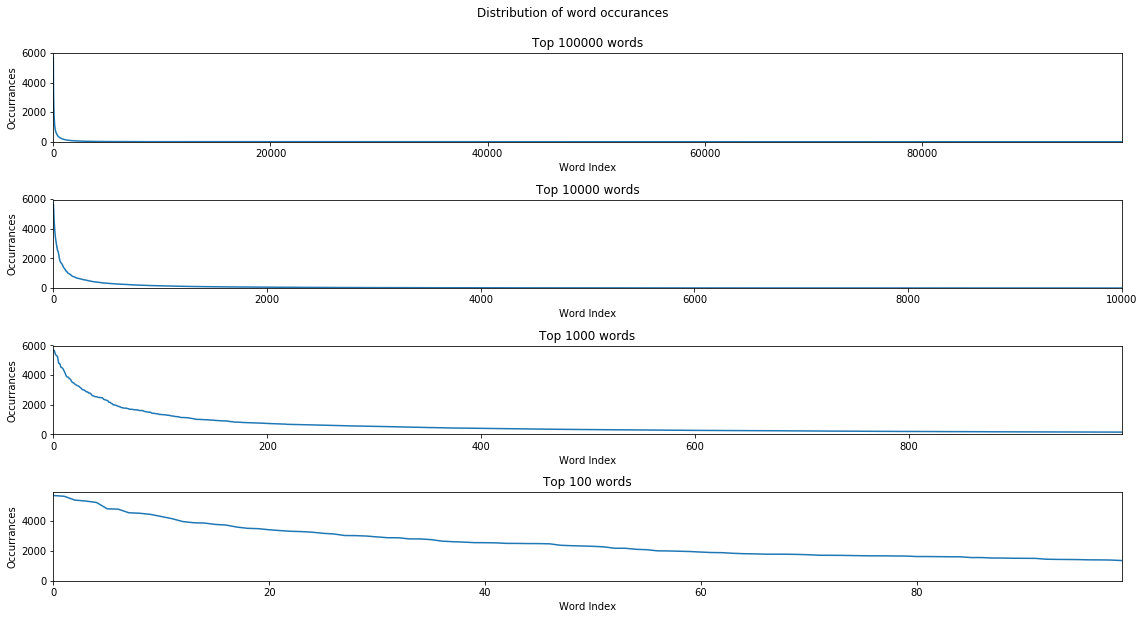

In [47]:
f, ax = plt.subplots(4, 1, figsize=(16,9))
#stemmed_dictionary_df[:100000]['occurrences'].plot(ax=ax[0], ylim=(0, None))
##stemmed_dictionary_df[:10000]['occurrences'].plot(ax=ax[1], ylim=(0, None))
#stemmed_dictionary_df[:1000]['occurrences'].plot(ax=ax[2], ylim=(0, None))
#stemmed_dictionary_df[:100]['occurrences'].plot(ax=ax[3], ylim=(0, None))

for i in range(4):
    stemmed_dictionary_df[:int(100000 / (10**i))]['occurrences'].plot(ax=ax[i], ylim=(0, None))
    ax[i].set_ylabel('Occurrances')
    ax[i].set_xlabel('Word Index')
    ax[i].set_title("Top {} words".format(int(100000 / (10**i))))

f.suptitle("Distribution of word occurances")
f.tight_layout(rect=[0, 0.03, 1, 0.95])

We see a super long tail of words.

In [48]:
stemmed_dictionary_df.head(40)

,word,occurrences,Occurs in %
0,:,5692,94.223
1,.,5642,93.395
2,",",5386,89.157
3,the,5322,88.098
4,to,5227,86.525
5,a,4802,79.490
6,and,4783,79.176
7,http,4540,75.153
8,of,4508,74.623
9,for,4433,73.382


In [50]:
print("{} words occur in no more than one email".format(len(stemmed_dictionary_df[stemmed_dictionary_df['occurrences'] == 1])))

65762 words occur in no more than one email


We have some words that appear in most mails, and a lot that appear in very few mails.

I will try to reduce the size of the data by PCA on the bag of word dimension space.

# What's next?
We have transformed the bodies and subjects of all emails from strings to vectors of strings representing words and other tokens. We have applied stemming to all these tokens in an attempt to standardise the emails by not taking word forms in to account. 

We have seen that many words appear in very few emails. Eventually I will represent emails as one-hot vectors, with every vector representing a word in the vocabulary. Allowing words that are only present in a single mail to represent a dimension of it's own will lead to a very large amount of dimensions. Probably unnecessarily large. I will apply PCA to the data set to reduce it's size.

Let's move on to notebook `3. Dimensionality reduction with PCA`.

In [53]:
data[['dataset', 'subject', 'body']].to_csv('stemmed_data.csv')